<a href="https://colab.research.google.com/github/Pareek-Yash/ImageGeneration_with_DCGAN/blob/main/Image_Generation_with_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile



#Initializing the Parameters

###Initalizing Parameters at one place helps in tweaking all parameters from one place for optimizing the Network.



In [16]:
alpha = 0.2
latent_dim = 128
lr = 0.001
batch_size = 32
codings_size = 128
num_epochs = 50

In [ ]:
data = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
os.makedirs("celeba_gan")

with ZipFile("/content/celeba_gan.zip", "r") as zip_ref:
    zip_ref.extractall("celeba_gan")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [5]:
for dirpath, dirnames, filenames in os.walk("celeba_gan"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'celeba_gan'.
There are 0 directories and 2000 images in 'celeba_gan/celeba_gan'.


In [6]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_folder):

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['001169.jpg']
Image shape: (218, 178, 3)


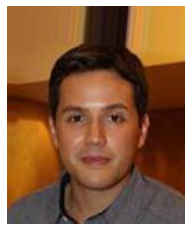

In [7]:
img = view_random_image(target_folder="/content/celeba_gan/celeba_gan")

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
data_dir ='/content/celeba_gan/'
train_data = datagen.flow_from_directory(
  directory=data_dir, target_size=(64, 64), batch_size=32, seed=42
)

Found 2000 images belonging to 1 classes.


In [10]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 2000 files belonging to 1 classes.




#Creating the Discriminator


In [11]:
discriminator = keras.Sequential(
    [
     keras.Input(shape=(64,64,3)),
     layers.Conv2D(64, kernel_size=5, strides=2, padding='same'),
     layers.LeakyReLU(alpha=alpha),
     layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
     layers.LeakyReLU(alpha=0.2),
     layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
     layers.LeakyReLU(alpha=0.2),

     layers.Flatten(),
     layers.Dropout(0.2),
     layers.Dense(1, activation="sigmoid"),
    ],
    name = "discriminator"
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)           

In [12]:
from tensorflow.python.keras.layers.normalization.batch_normalization import BatchNormalization
generator = keras.Sequential(
    [
      keras.Input(shape=(latent_dim,)),
      layers.Dense(8*8*128),
      layers.Reshape((8, 8, 128)),
      layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      52

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [14]:
class save_imgs(keras.callbacks.Callback):
    def __init__(self, num_img=3, codings_size=128):
        self.num_img = num_img
        self.codings_size = codings_size

    def on_epoch_end(self, epoch, logs=None):
        noise = tf.random.normal(shape=(self.num_img, self.codings_size))
        generated_images = self.model.generator(noise)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [22]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, codings_size, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.codings_size = codings_size
        self.batch_size = batch_size

    def compile(self, d_opt, g_opt, loss_fn):
        '''
        To customize the fit method you should override the training step function of the Model class.
        This is the function that is called by fit() for every batch of data.
        This will allow us using the fit() method normally but with our own custom modification
        https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
        '''
        super(GAN, self).compile()
        self.d_optimizer = d_opt
        self.g_optimizer = g_opt
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=[batch_size, self.codings_size])
        
        # Create fake images
        generated_images = self.generator(noise)

        X_fake_and_real = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        y1 = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        y1 += 0.05 * tf.random.uniform(tf.shape(y1))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(X_fake_and_real)
            d_loss = self.loss_fn(y1, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Phase 2
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Assemble labels that say "all real images"
        y2 = tf.zeros((batch_size, 1))

        # Train the generator with discriminator **OFF**
        discriminator.trainable = False
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(y2, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [23]:
gan = GAN(discriminator=discriminator, generator=generator, codings_size=codings_size, batch_size=batch_size)
gan.compile(
    d_opt=keras.optimizers.Adam(learning_rate=0.0001),
    g_opt=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=1, callbacks=[save_imgs(num_img=10, codings_size=codings_size)]
)

63/63 [==============================] - 1640s 26s/step - d_loss: 0.6346 - g_loss: 0.5687


In [ ]:
import matplotlib.image as mpig
import random

def view_gen_image(target_folder):

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpig.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

In [ ]:
view_gen_images(/content)